# Homework 4 - Andrew Schwartz - PHYS 403, SPR 2024

## 1. Computing a posterior PDF

Download two data sets from Blackboard, which give $x$, $y$, $\delta y$ for 10 data points, where $\delta y$ is the Gaussian uncertainty on $y$. The data are generated from a linear model with zero intercept, i.e. $y = f(x) = mx$, where $m$ is a slope parameter.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 🥧
π = np.pi


def load(data):
    """load xᵢ,yᵢ data, and δy from given strings"""
    return np.fromstring(data, dtype=float, sep=' ').reshape((10, 3)).T


data = [load(data) for data in ["""0 -0.1 0.40
1 3.0 0.40
2 6.5 0.40
3 9.4 0.40
4 12.7 0.40
5 15.8 0.40
6 18.7 0.40
7 22.1 0.40
8 24.6 0.40
9 28.2 0.40""", """0 1.6 4.00
1 -0.6 4.00
2 4.3 4.00
3 4.9 4.00
4 2.8 4.00
5 15.7 4.00
6 16.8 4.00
7 21.8 4.00
8 29.1 4.00
9 29.8 4.00"""]]

### (a) 

Using a uniform prior, plot the posterior probability density as a function of $m$, for $m$ between 0 and 10. Which data are more precise?

### Solution

Want: $p(m|D,I)\propto p(D|m,I)p(m|I)$.
$p(m|I)=1/10$
D is the $n$ $x_i,y_i$ pairs.
$$
p(D|m,I)=\prod_{i=1}^np(y_i|x_i,m)=\left(\frac{1}{2\pi\delta_y^2}\right)^{\frac{n}{2}}\exp\left(-\frac{1}{2\delta_y^2}(m \vec{x}-\vec{y})^2\right)
$$

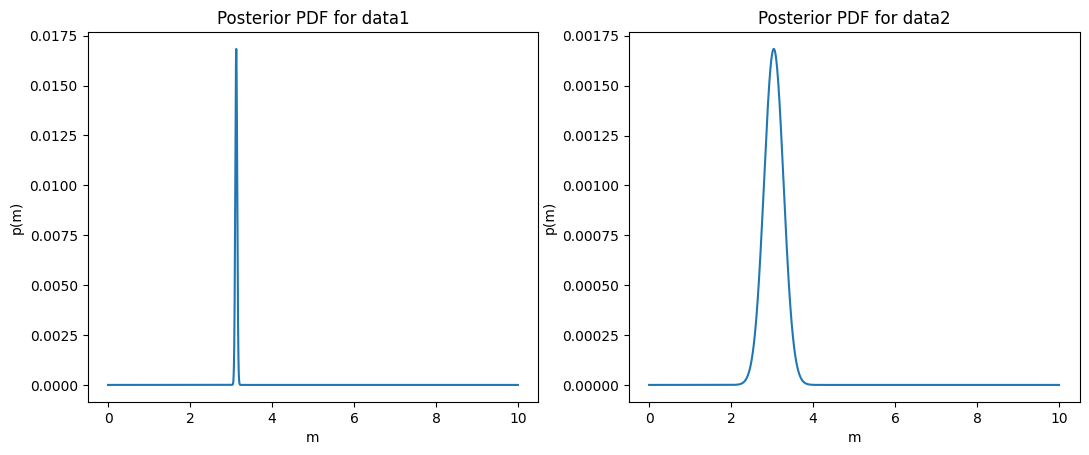

In [14]:
uniform_prior = lambda m: 1 / 10

def posterior(prior, m, x, y, δy):
    """return the posterior pdf p(m|D) where D is the x,y data given a prior"""
    δy = δy[0]
    n = len(x)
    return prior(m) * (1 / (2 * π * δy ** 2)) ** (n / 2) * np.exp(-1 / (2 * δy ** 2) * np.sum((m * x - y) ** 2))


fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
m = np.linspace(0, 10, 10000)

# calculate pdf values at m∈[0,10]
pdfs = np.array([[posterior(uniform_prior, m, *data[i]) for m in m] for i in range(2)])
# normalize to 1
pdfs /= np.sum(pdfs, axis=1)[:, np.newaxis]

for i in range(2):
    ax[i].plot(m, pdfs[i], label=f'data{i+1}')
    ax[i].set(xlabel='m', ylabel='p(m)', title=f"Posterior PDF for data{i+1}")

We find that data1 is more precise, since it has a sharper peak in its Gaussian.

### (b)

Determine the MPV of the posterior PDF. Determine the range of values that include 68% and 90% of the probability by integrating the PDF (it is fine to integrate a plot numerically, you do not need to express the PDF itself in closed form).


In [48]:
from prettytable import PrettyTable

# mpv is the index of the max probability
mpv = np.argmax(pdfs, axis=1)
# mpm is the most probable m
mpm = m[mpv]
# mpvv is the probability at the most probable m
mpvv = pdfs[(0, 1), mpv]

t = PrettyTable(["", "data1", "data2"], float_format=".3")
t.add_row(["mpv", *mpm])
t.add_row(["p(mpv)", *mpvv])
print(t)

+--------+-------+-------+
|        | data1 | data2 |
+--------+-------+-------+
|  mpv   | 3.128 | 3.041 |
| p(mpv) | 0.017 | 0.002 |
+--------+-------+-------+


+-----+-------------------------+-------------------------+
|     |          data1          |          data2          |
+-----+-------------------------+-------------------------+
| 68% | [3.10431043 3.15131513] | [2.80528053 3.27632763] |
| 90% | [3.08830883 3.16631663] | [2.65126513 3.43034303] |
+-----+-------------------------+-------------------------+


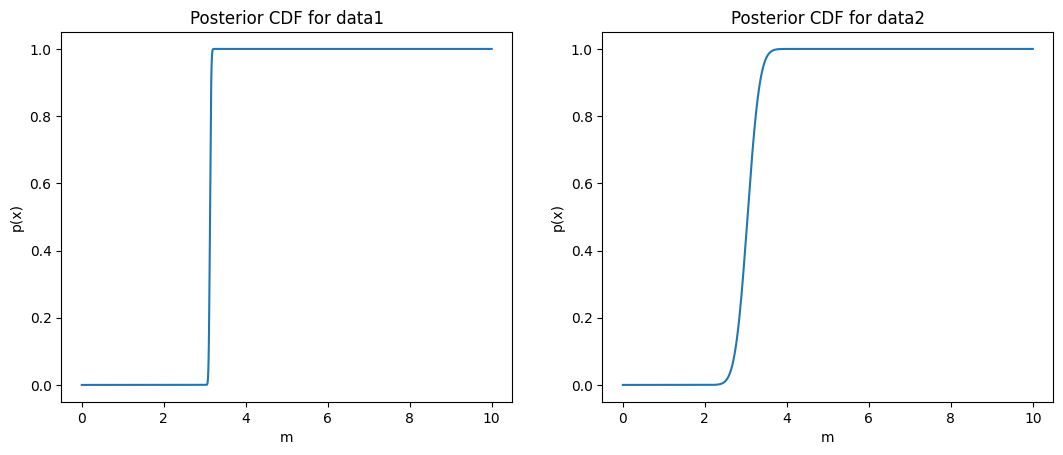

In [45]:
# numerically integrate pdfs
cdfs = np.add.accumulate(pdfs, axis=1)

# find idx of closest cdf to val
nearest_idx = lambda val: np.argmin(np.abs(cdfs - val), axis=1)


def calc_range(pct):
    """Calculate the [lower, upper] bounds which pct% of the data is between"""
    lower_bound = (1 - pct) / 2
    return m[np.array([nearest_idx(lower_bound), nearest_idx(1 - lower_bound)]).T]


t = PrettyTable(["", "data1", "data2"])
t.add_row(["68%", *calc_range(0.68)])
t.add_row(["90%", *calc_range(0.90)])
print(t)

fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))

for i in range(2):
    ax[i].plot(m, cdfs[i])
    ax[i].set(xlabel='m', ylabel='p(x)', title=f"Posterior CDF for data{i + 1}")

### (c)

Use instead a Gaussian prior on $m$. Show that if you choose $\mu$ to be far from the MPV from part (b), and $\sigma$ sufficiently small, you get a different posterior PDF.

+--------------+-------+-------+
|              | data1 | data2 |
+--------------+-------+-------+
| gaussian mpv | 3.223 | 7.105 |
| uniform mpv  | 3.128 | 3.041 |
+--------------+-------+-------+


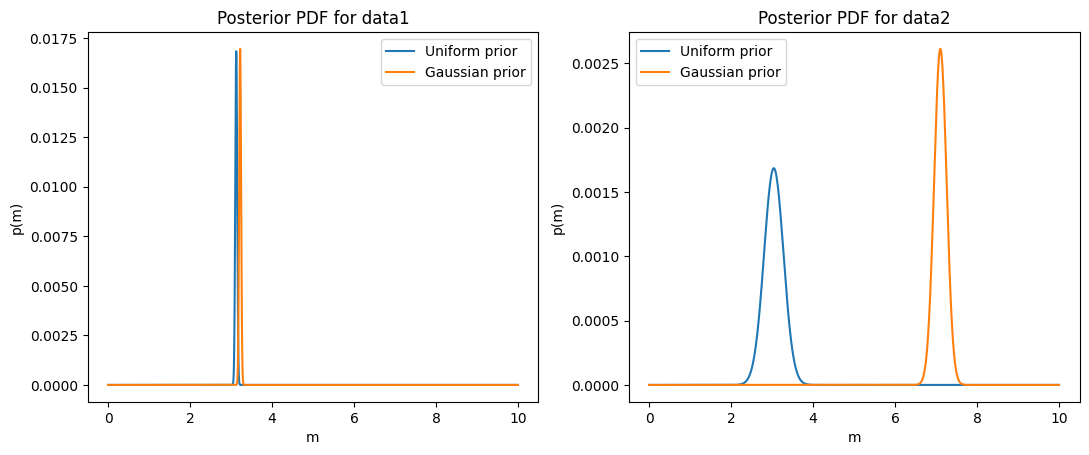

In [44]:
def gaussian_prior(m):
    """is what the name says"""
    μ, σ2 = 10, 0.04
    return (1 / 2 * π * σ2) ** 1 / 2 * np.exp(-1 / (2 * σ2) * (m - μ) ** 2)


fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
m = np.linspace(0, 10, 10000)

pdfs_gaussian = np.array([[posterior(gaussian_prior, m, *data[i]) for m in m] for i in range(2)])
# normalize to 1
pdfs_gaussian /= np.sum(pdfs_gaussian, axis=1)[:, np.newaxis]

for i in range(2):
    ax[i].plot(m, pdfs[i], label='Uniform prior')
    ax[i].plot(m, pdfs_gaussian[i], label='Gaussian prior')
    ax[i].set(xlabel='m', ylabel='p(m)', title=f"Posterior PDF for data{i + 1}")
    ax[i].legend()
    
mpv_gaussian = np.argmax(pdfs_gaussian, axis=1)
t = PrettyTable(["", "data1", "data2"], float_format=".3")
t.add_row(["gaussian mpv", *m[mpv_gaussian]])
t.add_row(["uniform mpv", *m[mpv]])
print(t)

plt.show()

## 2. Estimator of a Poisson Mean

Consider a set of measurements $\vec{x} = \{x_i\}$ drawn from a Poisson distribution with mean $\lambda$.

### (a)

Find the best estimator $\hat\lambda$ of the mean.

### Solution

$$
\begin{align}
p(\lambda|\vec x)&=\prod_{i=1}^N p(x_i|\lambda) \\
&=\prod_{i=1}^N \frac{\lambda^x_i e^{-\lambda}}{x_i!}
\end{align}

\\

\begin{align}
L(\lambda|\vec x)&=\ln p(\lambda|\vec x) \\
&=\sum_{i=1}^N\ln\left(\frac{\lambda^x_i e^{-\lambda}}{x_i!}\right) \\
&=\sum_{i=1}^Nx_i\ln\lambda-\lambda-\ln x_i! \\
&=-N\lambda+\sum_{i=1}^Nx_i\ln\lambda-\ln x_i!
\end{align}

\\

\begin{align}
0&=\frac{dL}{d\lambda}\Big|_\hat\lambda \\
&=-N+\sum_{i=1}^N\frac{x_i}{\hat\lambda} \\
\therefore\ \ \hat\lambda&=\frac{1}{N}\sum_{i=1}^N x_i
\end{align}

$$

### (b)

Find the bias of the estimator $\hat\lambda$.

### Solution

$$
\begin{align}
b&=\langle\hat\lambda\rangle-\lambda \\
&=\frac{1}{N}\left\langle\sum_{i=1}^N x_i\right\rangle-\lambda \\
&=\frac{N\lambda}{N}-\lambda \\
&=0
\end{align}
$$

### (c)

Find the mean squared error (MSE) of $\hat\lambda$.

### Solution

$$
\begin{align}
\text{MSE}&=\text{var}(\hat\lambda)+b^2 \\
&=\frac{1}{N}\text{var}\left( x_i\right) \\
&=\frac{1}{N^2}\text{var}(\sum_{i=1}^N x_i) \\
&=\frac{N\lambda}{N^2} \\
&=\frac{\lambda}{N}
\end{align}
$$

## 3. Estimators of Gaussian Variance

Consider a Gaussian distribution with mean $\mu = 0$ and variance $\sigma^2 = 1$. Given $N > 1$ independent measurements $x_i$ drawn from this distribution, the sample variance $s^2$ can be calculated using the expression

$$
s^2=\frac{1}{N-1}\sum_{i=1}^N\left(x_i-\bar x\right)^2.
$$

(a)

Given that $(N-1)s^2/\sigma^2$ follows a $\chi^2$ distribution with $N-1$ degrees of freedom, show that $s^2$ is an unbiased estimator of the variance $\sigma^2$, and that
$$
\text{var}(s^2)=2/(N-1).
$$

*Hint: it may help to use the expectation value and variance of $\chi_{N-1}^2$ in your solution.*

### Solution

For a variable $x\sim\chi_{N-1}^2$, $\langle x\rangle=N-1$ and $\text{var}(x)=2(N-1)$.

$$
\begin{align}
\langle s^2\rangle&=\frac{\sigma^2}{N-1}\left\langle(N-1)\frac{s^2}{\sigma^2}\right\rangle \\
&=\frac{\sigma^2}{N-1}(N-1) \\ 
&= \sigma^2
\end{align}

\\

\begin{align}
b&=\langle s^2\rangle-\sigma^2 \\
&=\sigma^2-\sigma^2 \\
&=0
\end{align}
$$
So it is an unbiased estimator.

$$
\begin{align}
\text{var}(s^2)&=\left(\frac{\sigma^2}{N-1}\right)^2\text{var}\left((N-1)\frac{s^2}{\sigma^2}\right) \\
&=\left(\frac{\sigma^2}{N-1}\right)^22(N-1) \\
&=\frac{2\sigma^4}{N-1} \\
&=\frac{2}{N-1}\text{, since }\sigma^2=1.
\end{align}
$$

### (b)

Find the expectation values and variances of other estimates

$$
s_k^2=\frac{1}{N+k}\sum_{i=1}^N\left(x_i-\bar x\right)^2
$$

where $k$ is an integer. Show that although the $k=1$ value $s_1^2$ is a biased estimator of $\sigma^2$, its mean square deviation from unity (i.e., the MSE $d_k^2=\text{var}(s_k^2)+b^2$, where $b$ is the bias) is smaller than for any other $s_k^2.$

### Solution

Using the fact that 
$$
s_k^2=\frac{1}{N+k}\sum_{i=1}^N\left(x_i-\bar x\right)^2=\frac{N-1}{N+k}s^2
$$

##### Expectation value
$$
\begin{align}
\langle s_k^2\rangle&=\frac{N-1}{N+k}\langle s^2\rangle=\frac{N-1}{N+k}\sigma^2
\end{align}
$$

##### Variance
$$
\begin{align}
\text{var}(s_k^2)=\left(\frac{N-1}{N+k}\right)^2\text{var}(s^2)=2\sigma^4\frac{N-1}{(N+k)^2}
\end{align}
$$

##### Bias
$$
\begin{align}
b_k&=\langle s_k^2\rangle-\sigma^2 \\
&=\sigma^2(\frac{N-1}{N+k}-1) \\
&=-\sigma^2\frac{k+1}{N+k}
\end{align}
$$

So $b_1=-\sigma^2\frac{2}{N+1}$

##### MSE
$$
\begin{align}
d_k^2&=\text{var}(s_k^2)+b_k^2 \\
&=2\sigma^4\frac{N-1}{(N+k)^2}+\left(\sigma^2\frac{k+1}{N+k}\right)^2 \\
&=\frac{2(N-1)+(k+1)^2}{(N+k)^2}\sigma^4 \\
\end{align}

\\

\begin{align}
0=\frac{\mathrm d d_k^2}{\mathrm dk}&=\frac{2(k+1)}{(k+N)^2}-\frac{2\left((k+1)^2+2(N-1)\right)}{(k+N)^3}\quad\text{from Mathematica} \\
\therefore\quad k=1
\end{align}
$$